In [3]:
import sympy as sp 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const

write the equation for myamoto nagai

In [4]:
def create_ellipsoid(eigenvalues, num_points=100):
    """
    Creates an ellipsoid based on the eigenvalues (semi-axes).
    
    Parameters:
    eigenvalues : array-like
        The eigenvalues that represent the lengths of the semi-axes of the ellipsoid.
    num_points : int
        The number of points for parametric plotting of the ellipsoid.
    
    Returns:
    (x, y, z) : tuple
        The coordinates of the points on the ellipsoid.
    """
    # Extract eigenvalues (semi-axes)
    a, b, c = np.sqrt(eigenvalues)
    
    # Parametric grid for spherical coordinates
    theta = np.linspace(0, 2 * np.pi, num_points)
    phi = np.linspace(0, np.pi, num_points)
    theta, phi = np.meshgrid(theta, phi)
    
    # Parametric equations for the ellipsoid
    x = a * np.sin(phi) * np.cos(theta)
    y = b * np.sin(phi) * np.sin(theta)
    z = c * np.cos(phi)
    
    return x, y, z


In [5]:
def rotate_ellipsoid(x, y, z, eigenvectors):
    """
    Rotates the ellipsoid based on the eigenvectors.
    
    Parameters:
    x, y, z : arrays
        Coordinates of the ellipsoid.
    eigenvectors : array-like
        The eigenvectors representing the rotation matrix for the ellipsoid's orientation.
    
    Returns:
    (x_rot, y_rot, z_rot) : tuple
        The rotated coordinates of the ellipsoid.
    """
    # Convert eigenvectors to a rotation matrix
    rotation_matrix = np.array(eigenvectors).T  # Transpose to match the correct rotation convention
    
    # Reshape the ellipsoid coordinates into a list of points
    points = np.vstack([x.ravel(), y.ravel(), z.ravel()])
    
    # Rotate the points using the rotation matrix
    rotated_points = rotation_matrix.dot(points)
    
    # Reshape back to the original shape
    x_rot, y_rot, z_rot = rotated_points[0].reshape(x.shape), rotated_points[1].reshape(y.shape), rotated_points[2].reshape(z.shape)
    
    return x_rot, y_rot, z_rot


In [6]:
def azimuthal_rotation(theta):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rotation = np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta, cos_theta, 0],
        [0, 0, 1]
    ])
    return rotation    


In [7]:
# create the tidal tensor for a Miyamoto-Nagai potential
R, z, a, b, G, M = sp.symbols('R z a b G M', real=True, positive=True)

# Define the potential (Miyamoto–Nagai)
beta = sp.sqrt(z**2 + b**2)
gamma = a + beta
d = sp.sqrt(R**2 + gamma**2)
Phi = -G * M / d

# First and second derivatives
dPhi_dR = sp.diff(Phi, R)
dPhi_dz = sp.diff(Phi, z)

d2Phi_dR2 = sp.diff(dPhi_dR, R)
d2Phi_dz2 = sp.diff(dPhi_dz, z)
d2Phi_dRdz = sp.diff(dPhi_dR, z)

# Tidal tensor in orthonormal basis
T = sp.Matrix([
    [d2Phi_dR2, 0, d2Phi_dRdz],
    [0, dPhi_dR / R, 0],
    [d2Phi_dRdz, 0, d2Phi_dz2]
])
T


Matrix([
[-3*G*M*R**2/(R**2 + (a + sqrt(b**2 + z**2))**2)**(5/2) + G*M/(R**2 + (a + sqrt(b**2 + z**2))**2)**(3/2),                                              0,                                                                                                                                                                                                                                                                         -3*G*M*R*z*(a + sqrt(b**2 + z**2))/((R**2 + (a + sqrt(b**2 + z**2))**2)**(5/2)*sqrt(b**2 + z**2))],
[                                                                                                      0, G*M/(R**2 + (a + sqrt(b**2 + z**2))**2)**(3/2),                                                                                                                                                                                                                                                                                                                                

In [8]:
# lamndify the tensor
tidal_tensor_func = sp.lambdify((R, z, a, b, G, M), T, "numpy")

In [9]:
xlim = (-2, 2)
ylim = (-2, 2)
zlim = (-2, 2)
AXIS={
    "xlim": xlim,
    "ylim": ylim,
    "zlim": zlim,
    "aspect": "equal",
    "xticklabels": [],
    "yticklabels": [],
    "zticklabels": [],
    "xticks": [],
    "yticks": [],
    "zticks": [],
}

In [10]:
# Set values for the parameters
a_val = 4  # Miyamoto-Nagai scale parameter (kpc)
b_val = 1  # Miyamoto-Nagai scale parameter (kpc)
G_val = 4.302e-6  # Gravitational constant in units of kpc * Msun^-1 * (km/s)^2
M_val = 1e6  # Example mass in solar masses

In [11]:
# test parameters 
n_shapes  = 9
num_points=100
R_vals = np.linspace(1, 4, n_shapes)
z_vals = np.linspace(1, 3, n_shapes)
theta_vals = np.linspace( 0, np.pi,n_shapes)
# store the eigen value and eigen vector
xs,ys,zs=np.zeros((n_shapes,num_points, num_points)),np.zeros((n_shapes,num_points, num_points)),np.zeros((n_shapes,num_points, num_points))
x_pos,y_pos,z_pos = np.zeros(n_shapes),np.zeros(n_shapes),np.zeros(n_shapes)
eigenvalues = np.zeros((n_shapes, 3))
eigenvectors = np.zeros((n_shapes, 3, 3))
# Create a colormap that scales with distance
mycmap = mpl.cm.get_cmap('rainbow', n_shapes)
r=np.sqrt(R_vals**2 + z_vals**2)
norm = mpl.colors.Normalize(vmin=np.min(r), vmax=np.max(r))
mycolors = [mycmap(norm(r_val)) for r_val in r]
# get the ellipsoid at the given position
for i in range(n_shapes):
    R_val = R_vals[i]
    z_val = z_vals[i]
    theta_val = theta_vals[i]
    # store the 3D cartesian position 
    x_pos[i] = R_val * np.cos(theta_val)
    y_pos[i] = R_val * np.sin(theta_val)
    z_pos[i] = z_val    
    # Calculate the tidal tensor at the given position
    T_result = tidal_tensor_func(R_val, z_val, a_val, b_val, G_val, M_val)
    # 2. Diagonalize to get principal axes
    diagonalized = np.linalg.eig(T_result)
    # store the eigenvalues and eigenvectors
    eigenvalues[i] = diagonalized.eigenvalues
    eigenvectors[i] = diagonalized.eigenvectors
    # 3. Create the ellipsoid aligned with principal axes
    x, y, z = create_ellipsoid(np.abs(diagonalized.eigenvalues),num_points=num_points)
    # 4. Rotate according to eigenvectors (this aligns the ellipsoid with principal axes)
    x_rot, y_rot, z_rot = rotate_ellipsoid(x, y, z, diagonalized.eigenvectors)
    # 5. Rotate around z-axis by theta_val
    rotation = azimuthal_rotation(theta_val)
    # Apply this second rotation
    points = np.vstack([x_rot.ravel(), y_rot.ravel(), z_rot.ravel()])
    rotated_points = rotation.dot(points)
    # Reshape back
    x_final = rotated_points[0].reshape(x.shape)
    y_final = rotated_points[1].reshape(y.shape)
    z_final = rotated_points[2].reshape(z.shape)
    # 7 translate the ellipsoid to the desired position
    xs[i] = x_final + x_pos[i]
    ys[i] = y_final + y_pos[i]
    zs[i] = z_final + z_pos[i]

/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_46573/3985748602.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mycmap = mpl.cm.get_cmap('rainbow', n_shapes)


In [12]:
eigenvalues[1]

array([ 0.0258969 , -0.00168952,  0.02242845])

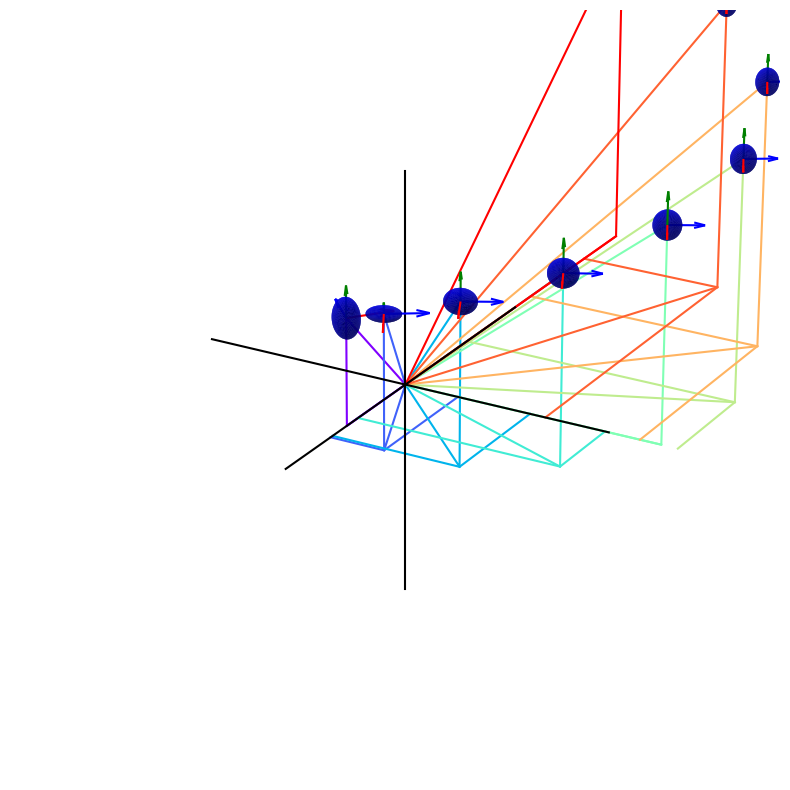

In [13]:
# Create the figure and 3D axis
fig = plt.figure(figsize=(11, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the ellipsoid
for i in range(n_shapes):
    # Plot the ellipsoid
    ax.plot_surface(xs[i], ys[i], zs[i], color='b', alpha=1)
    #ax.plot_wireframe(xs[i], ys[i], zs[i], color='k', alpha=0.5)
    # plot the position
    line,=ax.plot([0, x_pos[i], x_pos[i] ], [0, y_pos[i], y_pos[i]], [0, 0, z_pos[i]], '-', markersize=5,color=mycolors[i])

    # make a line coming out of the x-axis to the position
    ax.plot([x_pos[i], x_pos[i]], [0, y_pos[i]], [0, 0], '-', c=line.get_color())
    # make a line coming out of the y-axis to the position
    ax.plot([0, x_pos[i]], [y_pos[i], y_pos[i]], [0, 0], '-',c=line.get_color())

    # plot the radial line
    ax.plot([0, x_pos[i]], [0, y_pos[i]], [0, z_pos[i]], '-', c=line.get_color())
    
    # add the ellipsoid axes
    scaled_eigenvalues = np.sqrt(np.abs(eigenvalues[i]))
    # sort for the largest eigenvalue first 
    sorted_indices = np.argsort(scaled_eigenvalues)[::-1]
    scaled_eigenvalues = scaled_eigenvalues[sorted_indices]
    scaled_eigenvectors = eigenvectors[i][:, sorted_indices]

    scaled_eigenvectors = eigenvectors[i] * scaled_eigenvalues
    factor = 5

    ax.quiver(x_pos[i], y_pos[i], z_pos[i], factor*scaled_eigenvectors[0,0], factor*scaled_eigenvectors[0,1], factor*scaled_eigenvectors[0,2], color='r', length=0.5)
    ax.quiver(x_pos[i], y_pos[i], z_pos[i], factor*scaled_eigenvectors[1,0], factor*scaled_eigenvectors[1,1], factor*scaled_eigenvectors[1,2], color='g', length=0.5)
    ax.quiver(x_pos[i], y_pos[i], z_pos[i], factor*scaled_eigenvectors[2,0], factor*scaled_eigenvectors[2,1], factor*scaled_eigenvectors[2,2], color='b', length=0.5)

# plot the axes
ax.plot(xlim, [0,0], [0,0], color='k' );
ax.plot([0,0], ylim, [0,0], color='k' );
ax.plot([0,0], [0,0], zlim, color='k' );
ax.set_axis_off()  # Turn off the axis lines and labels
ax.set(**AXIS);
ax.view_init(elev=24, azim=30, roll=0)  # Set the view angle


# Spherical case
Try to show that the longest eigen vector of the tidal tensor will always align with the radial vector 

In [14]:
# Variables
x, y, z, G, M = sp.symbols('x y z G M')
r = sp.sqrt(x**2 + y**2 + z**2)

# Potential
Phi = -G*M/r

# Force = grad(Phi)
grad_Phi = [sp.diff(Phi, var) for var in (x, y, z)]

# Hessian (tidal tensor)
tidal_tensor = -sp.Matrix([
    [sp.diff(grad_Phi[i], var) for var in (x, y, z)]
    for i in range(3)
])

tidal_tensor

Matrix([
[3*G*M*x**2/(x**2 + y**2 + z**2)**(5/2) - G*M/(x**2 + y**2 + z**2)**(3/2),                                    3*G*M*x*y/(x**2 + y**2 + z**2)**(5/2),                                    3*G*M*x*z/(x**2 + y**2 + z**2)**(5/2)],
[                                   3*G*M*x*y/(x**2 + y**2 + z**2)**(5/2), 3*G*M*y**2/(x**2 + y**2 + z**2)**(5/2) - G*M/(x**2 + y**2 + z**2)**(3/2),                                    3*G*M*y*z/(x**2 + y**2 + z**2)**(5/2)],
[                                   3*G*M*x*z/(x**2 + y**2 + z**2)**(5/2),                                    3*G*M*y*z/(x**2 + y**2 + z**2)**(5/2), 3*G*M*z**2/(x**2 + y**2 + z**2)**(5/2) - G*M/(x**2 + y**2 + z**2)**(3/2)]])

Note that sympy is having a hard time doing all the algebraic manipulations, like finding the eigen vectors. I will simplify this expression to find the tidal tensor. This can be done by replacing $x^2 + y^2 + z^2$ with $r^2$ and factoring out  $\frac{GM}{r^3}$ This way, I can have a "scaled" tidal tensor.

Note that below I introduce $r$ without establishing that it is $r^2=x^2 + y^2 + z^2$. With SymPy, this manouver keeps the equation neat and orderly. 

In [15]:
r,x,y,z=sp.symbols('r x y z', real=True)
T = -sp.Matrix(
    [1 - 3*x**2/r**2, 
     -3*x*y/r**2, 
     -3*x*z/r**2,
     -3*x*y/r**2,
     1 - 3*y**2/r**2,
     -3*y*z/r**2,
     -3*x*z/r**2,
     -3*y*z/r**2,
     1 - 3*z**2/r**2]
)
scaled_tidal_tensor=T.reshape(3,3)

Now create numpy functions from sympy 

In [16]:
scaled_tidal_tensor_func = sp.lambdify((r, x, y, z), scaled_tidal_tensor, "numpy")
scaled_tidal_tensor_func

<function _lambdifygenerated(r, x, y, z)>

## Play with the tidal field for the moon

There are many ways that the moon and the tides play together. The tides from the earth deform the shape of the moon, and thus the moon is tidally locked. The tides from the moon "fix" the Earth's water in an ellipse as the earth then moves around it. But, I want to know how much the moons orbit could deviate given the tidal field of the sun. 

Things to consider 
- The Earth has a non intertial reference frame as it orbits the sun 
- the moon-earth distance
- the gravitational strength of the earth
- the solar tidal field 

I want to compute the orbits of the moon by continually adding more corrections: 
1. The two body problem 
2. The tidal froces from the sun while in the earth's reference frame. 


Q. What is stronger? the tidal force or the centrigufal force? I wonder! 

In [17]:
# pick the units
unitL = u.au
unitT = u.yr
unitV = unitL / unitT
unitM = u.Msun
unitG=unitV**2 * unitL / unitM
G_val=const.G.to(unitG)
# Pick some values 
Msun = 1*u.Msun
Mearth= (1*u.Mearth).to(u.Msun)
Dearth= 1*u.au
Dmoon = 384400 * u.km # from google 
Dmoon = Dmoon.to(u.au)
omega = 2*np.pi / (1 * u.yr)
# drop the units 
Msun = Msun.value
Mearth = Mearth.value
Dearth = Dearth.value
Dmoon = Dmoon.value
omega = omega.value
G_val = G_val.value
# numerical parametesr 
npoints = 25

In [18]:
# pick a position of the earth 
time = 0.1
x_earth = Dearth * np.cos(omega * time)
y_earth = Dearth * np.sin(omega * time)
z_earth = 0
r_earth = np.sqrt(x_earth**2 + y_earth**2 + z_earth**2)
# eval the tidal tensor at the position of the earth
unscaled_tidal_tensor=scaled_tidal_tensor_func(r_earth, x_earth, y_earth, z_earth)
# scale the tidal tensor
tidal_tensor = unscaled_tidal_tensor * (G_val * Msun / Dearth**3)
# get the eigen vectors of the tidal tensor
unscaled_eigen = np.linalg.eig(unscaled_tidal_tensor)
eigen = np.linalg.eig(tidal_tensor)

In [19]:
# create a unit sphere 
npoints = 25
x_sphere = Dmoon*np.cos(np.linspace(0, 2 * np.pi, npoints))
y_sphere = Dmoon*np.sin(np.linspace(0, 2 * np.pi, npoints))
# scale them based on the eigenvalues
scaled_eigen = np.sqrt(np.abs(unscaled_eigen.eigenvalues))
x_sphere = scaled_eigen[0] * x_sphere
y_sphere = scaled_eigen[1] * y_sphere
# rotate the sphere based on the eigenvectors
surface_points = np.vstack([x_sphere.ravel(), y_sphere.ravel(), np.zeros_like(x_sphere.ravel())])
# rotate the points using the rotation matrix
rotation_matrix = np.array(unscaled_eigen.eigenvectors)  # Transpose to match the correct rotation convention
rotated_points = rotation_matrix.dot(surface_points)

In [20]:
# set the grid to evaulate the tidal forces around the earth
delta = 2*Dmoon
xs = np.linspace(-delta, delta, npoints)
ys = np.linspace(-delta, delta, npoints)
X, Y = np.meshgrid(xs, ys)
# prepare the vector outputs 
tidal_vectors = np.zeros((X.shape[0], X.shape[1], 3))  # For storing vectors
# make a list of coordinates
coords = np.zeros((3,X.flatten().shape[0]))
# fill in the coordinates
coords[0] = X.flatten()
coords[1] = Y.flatten()
coords[2] = np.zeros_like(X.flatten())
# compute the dot product 
tidal_force_vectors=tidal_tensor.dot(coords)
# Normalize the vectors
tidal_force_magnitude=np.linalg.norm(tidal_force_vectors, axis=0)
normalized_tidal_forces = tidal_force_vectors / tidal_force_magnitude
# compute the force from the earth 
distance_to_earth = np.sum(coords**2, axis=0)**0.5
earth_force_magnitude = (G_val*Mearth) * (1/distance_to_earth**2)
earth_force = -coords * earth_force_magnitude / distance_to_earth
normalized_earth_force = earth_force / earth_force_magnitude

# make the field for the centrifugal force
omega_vec = np.array([0, 0, omega])
centrifugalforce=np.cross(omega_vec.T,coords.T).T
centrifugalforce_magnitude = np.linalg.norm(centrifugalforce, axis=0)
# Normalize the vectors
normalized_centrifugalforce = centrifugalforce / centrifugalforce_magnitude


# make the net force vector 
net_force = tidal_force_vectors + earth_force + centrifugalforce
# normalize each of them 
norm_net_force = np.linalg.norm(net_force, axis=0)
normalized_net_force = net_force / norm_net_force

/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_46573/3136167987.py:18: RuntimeWarning: invalid value encountered in divide
  normalized_tidal_forces = tidal_force_vectors / tidal_force_magnitude
/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_46573/3136167987.py:21: RuntimeWarning: divide by zero encountered in divide
  earth_force_magnitude = (G_val*Mearth) * (1/distance_to_earth**2)
/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_46573/3136167987.py:22: RuntimeWarning: invalid value encountered in multiply
  earth_force = -coords * earth_force_magnitude / distance_to_earth
/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_46573/3136167987.py:30: RuntimeWarning: invalid value encountered in divide
  normalized_centrifugalforce = centrifugalforce / centrifugalforce_magnitude


In [21]:
# make a colormap for the magnitude of the force
vmax = 20
mycmap = mpl.colormaps.get_cmap('rainbow')
norm = mpl.colors.Normalize(vmin=np.min(tidal_force_magnitude), vmax=vmax)
colors_tidal = [mycmap(norm(force)) for force in tidal_force_magnitude]
colors_earth = mycmap(norm(earth_force_magnitude))
colors_centrifugal = mycmap(norm(centrifugalforce_magnitude))
AXIS={
    "xlim": (x_earth-delta, x_earth+delta),
    "ylim": (y_earth-delta, y_earth+delta),
    "aspect": "equal",
    "xlabel": "X [kpc]",
    "ylabel": "Y [kpc]",}

In [22]:
import matplotlib.font_manager as fm
# Check if the new font is now available
available_fonts = [f.name for f in fm.fontManager.ttflist]
emoji_fonts = [f for f in available_fonts if 'emoji' in f.lower() or 'noto' in f.lower()]
print("Available emoji fonts:", emoji_fonts)
emoji_font = fm.FontProperties(family='Noto Color Emoji')


Available emoji fonts: ['Noto Sans Gothic', 'Noto Serif Myanmar', 'Noto Sans Yi', 'Noto Sans Imperial Aramaic', 'Noto Sans Lycian', 'Noto Sans Modi', 'Noto Sans Khojki', 'Noto Sans Rejang', 'Noto Sans Hatran', 'Noto Sans Saurashtra', 'Noto Sans Bassa Vah', 'Noto Sans Newa', 'Noto Sans Batak', 'Noto Sans Egyptian Hieroglyphs', 'Noto Sans Kannada', 'Noto Sans Osmanya', 'Noto Sans Samaritan', 'Noto Sans Mandaic', 'Noto Sans Linear B', 'Noto Sans Syriac', 'Noto Sans PhagsPa', 'Noto Sans Marchen', 'Noto Sans Bhaiksuki', 'Noto Sans Coptic', 'Noto Sans Tifinagh', 'Noto Sans Linear A', 'Noto Sans Limbu', 'Noto Sans Carian', 'Noto Sans Old Permic', 'Noto Sans Sora Sompeng', 'Noto Sans Syloti Nagri', 'Noto Sans Cuneiform', 'Noto Sans Meroitic', 'Noto Sans Tagalog', 'Noto Serif Balinese', 'Noto Sans Chakma', 'Noto Sans Cham', 'Noto Sans Glagolitic', 'Noto Sans Phoenician', 'Noto Sans Gunjala Gondi', 'Noto Sans Lepcha', 'Noto Sans Mro', 'Noto Sans New Tai Lue', 'Noto Sans Ugaritic', 'Noto Sans Mul

In [29]:
# Add this at the top of your notebook
from matplotlib import offsetbox
from PIL import Image
from urllib.request import urlopen
import io

# Download a small earth image or use a local one
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/The_Blue_Marble_%28remastered%29.jpg/240px-The_Blue_Marble_%28remastered%29.jpg"
img_data = urlopen(url).read()
img = Image.open(io.BytesIO(img_data))

# For your plotting code
earth_img = offsetbox.OffsetImage(img, zoom=0.1)


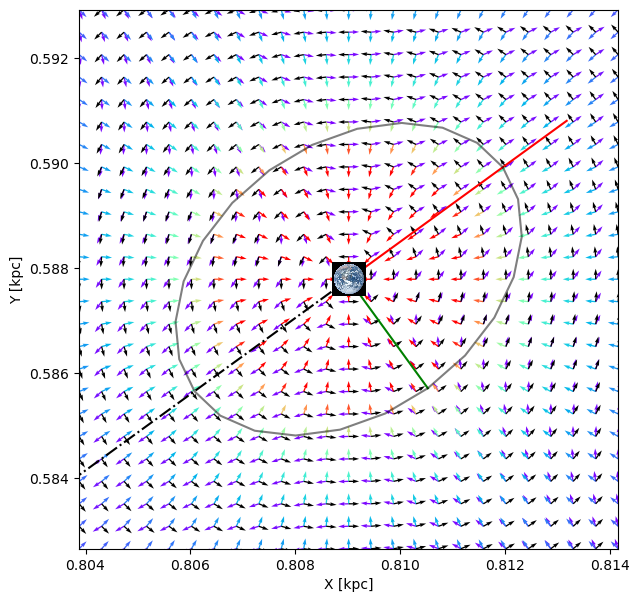

In [30]:
# plot the tidal field about the earth 
fig,axis=plt.subplots(figsize=(8, 7))
axis.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_tidal_forces[0], normalized_tidal_forces[1], color=colors_tidal,units="xy",scale=5000  )
axis.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_earth_force[0], normalized_earth_force[1], color=colors_earth,units="xy",scale=5000  )
axis.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_centrifugalforce[0], normalized_centrifugalforce[1], color='k',units="xy",scale=5000  )
axis.scatter(x_earth, y_earth, color='r', s=100)
# add the eigen vectors 
axis.plot([x_earth,x_earth+Dmoon*unscaled_eigen.eigenvalues[0]*unscaled_eigen.eigenvectors[0][0]],[y_earth,y_earth+Dmoon*unscaled_eigen.eigenvalues[0]*unscaled_eigen.eigenvectors[1][0]],'-', color='r')
axis.plot([x_earth,x_earth+Dmoon*unscaled_eigen.eigenvalues[1]*unscaled_eigen.eigenvectors[0][1]],[y_earth,y_earth+Dmoon*unscaled_eigen.eigenvalues[1]*unscaled_eigen.eigenvectors[1][1]],'-', color='g')
axis.plot([x_earth,x_earth+Dmoon*unscaled_eigen.eigenvalues[2]*unscaled_eigen.eigenvectors[2][0]],[y_earth,y_earth+Dmoon*unscaled_eigen.eigenvalues[2]*unscaled_eigen.eigenvectors[2][1]],'-', color='b')

# add the eart 
earth_annotation = offsetbox.AnnotationBbox(earth_img, (x_earth, y_earth), frameon=False)
axis.add_artist(earth_annotation)

axis.plot([0,x_earth],[0,y_earth],'-.', color='k')
# add the deformed shape 
axis.plot(x_earth+rotated_points[0],y_earth+rotated_points[1], color='k', alpha=0.5)

axis.set(**AXIS);

In [56]:
AXIS2 = {
    "xlim": (-Dearth, Dearth),
    "ylim": (-Dearth, Dearth),
    "aspect": "equal",
    "xlabel": "X [au]",
    "ylabel": "Y [au]",
}

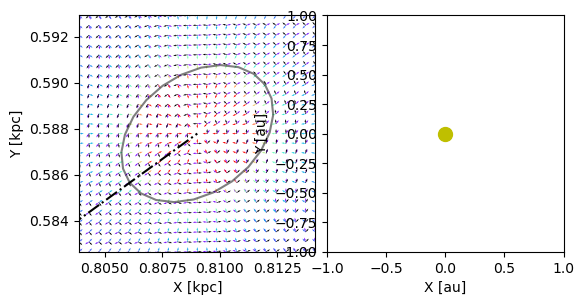

In [67]:
fig=plt.figure(figsize=(8.25-2, (11.75-2)/3))
gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.05)
axis1 = fig.add_subplot(gs[0])
axis2 = fig.add_subplot(gs[1])
axis1.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_tidal_forces[0], normalized_tidal_forces[1], color=colors_tidal,units="xy",scale=5000  )
axis1.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_earth_force[0], normalized_earth_force[1], color=colors_earth,units="xy",scale=5000  )
axis1.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_centrifugalforce[0], normalized_centrifugalforce[1], color='k',units="xy",scale=5000  )
axis1.plot([0,x_earth],[0,y_earth],'-.', color='k')
axis1.set(**AXIS);
axis1.plot(x_earth+rotated_points[0], y_earth+rotated_points[1], color='k', alpha=0.5)
# add the positions 
# axis2.scatter(x_earth, y_earth, color='b', s=10)
axis2.scatter(0,0, color='y', s=100)
axis2.set(**AXIS2);